In [98]:
# choromorph_svg_distortion.py
# ---------------------------------------------------------------------------
# Prerequisites (run once if needed):
#   pip install choromorph svgpathtools numpy scipy matplotlib
# ---------------------------------------------------------------------------

import re
import xml.etree.ElementTree as ET
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from svgpathtools import svg2paths, wsvg, Line, Path as SVGPath
from choromorph import choromorph
from IPython.display import SVG
from matplotlib.patches import PathPatch
from matplotlib.path import Path as MplPath

In [99]:

# ─────────────────────────────────────────────────────────────────────────────
# CONFIGURE YOUR INPUT / OUTPUT
# ─────────────────────────────────────────────────────────────────────────────
svg_file   = Path("../images/italy_map_no_grid.svg")          # original SVG (Italy outline, etc.)
output_svg = Path("../images/italy_map_no_grid_warped.svg")   # warped output path

# Mesh density (40×40 is a good start for country-sized shapes)
n_x, n_y = 150, 150

# Choromorph parameters
alpha     = 0.05
beta      = 0.1
max_iter  = 80
max_step  = 10


In [100]:

# ─────────────────────────────────────────────────────────────────────────────
# 1. Load SVG paths safely (skip shape‑to‑path conversion that may fail)
# ─────────────────────────────────────────────────────────────────────────────
paths, _ = svg2paths(
    str(svg_file),
    return_svg_attributes=False,
    convert_circles_to_paths=False,
    convert_ellipses_to_paths=False,
    convert_lines_to_paths=False,
    convert_polylines_to_paths=False,
    convert_polygons_to_paths=False,
    convert_rectangles_to_paths=False,
)
if not paths:
    raise ValueError("No <path> elements found – convert your SVG shapes to paths.")


In [101]:

# ─────────────────────────────────────────────────────────────────────────────
# 2. Robust viewBox / size reader
# ─────────────────────────────────────────────────────────────────────────────
def _parse_viewbox_or_size(svg_path: Path):
    """Return vb_x, vb_y, vb_w, vb_h even if <svg> lacks a viewBox."""
    root = ET.parse(svg_path).getroot()

    # 1) Explicit viewBox
    if "viewBox" in root.attrib:
        return map(float, root.attrib["viewBox"].split())

    # helper: strip CSS units → float
    _to_float = lambda s: float(re.sub(r"[a-zA-Z%]+$", "", s))

    # 2) width / height attributes
    if "width" in root.attrib and "height" in root.attrib:
        w = _to_float(root.attrib["width"])
        h = _to_float(root.attrib["height"])
        return 0.0, 0.0, w, h

    # 3) Fallback – compute bbox from all paths
    pths, _ = svg2paths(str(svg_path), return_svg_attributes=False)
    if not pths:
        raise ValueError("SVG has neither viewBox, size, nor path geometry.")
    min_x = min(seg.bbox()[0] for p in pths for seg in p)
    min_y = min(seg.bbox()[1] for p in pths for seg in p)
    max_x = max(seg.bbox()[2] for p in pths for seg in p)
    max_y = max(seg.bbox()[3] for p in pths for seg in p)
    return min_x, min_y, (max_x - min_x), (max_y - min_y)


vb_x, vb_y, vb_w, vb_h = _parse_viewbox_or_size(svg_file)


In [102]:

# ─────────────────────────────────────────────────────────────────────────────
# 3. Build regular 2‑D mesh covering the SVG viewBox
# ─────────────────────────────────────────────────────────────────────────────
xs = np.linspace(vb_x, vb_x + vb_w, n_x)
ys = np.linspace(vb_y, vb_y + vb_h, n_y)
X, Y = np.meshgrid(xs, ys)
grid = np.column_stack((X.ravel(), Y.ravel()))

# Grid connectivity (horizontal & vertical neighbours)
edges = []
for j in range(n_y):
    for i in range(n_x):
        idx = j * n_x + i
        if i < n_x - 1:  # horizontal
            edges.append((idx, idx + 1))
        if j < n_y - 1:  # vertical
            edges.append((idx, idx + n_x))
edges = np.asarray(edges, dtype=int)


In [103]:
# -----------------------------------------------------------------
# 4. Converte lon/lat → Web-Mercator → spazio SVG
# -----------------------------------------------------------------
from pyproj import Transformer
import math, json

# 4-A ➊ carica GeoJSON
gj = json.loads(Path("../poster/data/clinics_ivg_2023_google_decode.geojson").read_text())
raw_coords = [
    feat["geometry"]["coordinates"]
    for feat in gj["features"]
    if feat["geometry"] and feat["geometry"]["coordinates"]
    and not any(math.isnan(c) for c in feat["geometry"]["coordinates"])
]

# 4-B ➋ lon/lat → EPSG:3857 (metri)
proj = Transformer.from_crs("EPSG:4326", "EPSG:4326", always_xy=True)
merc_x, merc_y = zip(*(proj.transform(lon, lat) for lon, lat in raw_coords))
merc_x, merc_y = np.asarray(merc_x), np.asarray(merc_y)

# 4-C ➌ calcola bbox della mappa in 3857
# 👉 puoi calcolarlo una volta e metterlo hard-coded
ITALY_X_MIN, ITALY_X_MAX = proj.transform(6.0, 0)[0], proj.transform(19.0, 0)[0]
ITALY_Y_MIN, ITALY_Y_MAX = proj.transform(0, 36.0)[1], proj.transform(0, 47.5)[1]

# 4-D ➍ riscalamento e flip-Y per l’SVG
x_svg = (merc_x - ITALY_X_MIN) / (ITALY_X_MAX - ITALY_X_MIN) * vb_w + vb_x
y_svg = (1 - (merc_y - ITALY_Y_MIN) / (ITALY_Y_MAX - ITALY_Y_MIN)) * vb_h + vb_y

pois = np.column_stack([x_svg, y_svg])

# (opzionale) limita il numero di PoI
MAX_POI = 500
if len(pois) > MAX_POI:
    rng = np.random.default_rng(42)
    pois = rng.choice(pois, size=MAX_POI, replace=False)

print(f"PoI finali: {len(pois)}")


PoI finali: 347


In [104]:


# ─────────────────────────────────────────────────────────────────────────────
# 5. Run Choromorph to warp the grid
# ─────────────────────────────────────────────────────────────────────────────
morphed, n_iter = choromorph(
    grid,
    pois,
    edges,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    max_step=max_step,
)
print(f"Choromorph converged in {n_iter} iterations")


# ─────────────────────────────────────────────────────────────────────────────
# 6. Prepare barycentric warp function via Delaunay triangulation
# ─────────────────────────────────────────────────────────────────────────────
tri = Delaunay(grid)

def barycentric_warp(pt: np.ndarray, src: np.ndarray, dst: np.ndarray, triangulation: Delaunay):
    """Warp a 2‑D point using barycentric coords between src & dst meshes."""
    simplex = triangulation.find_simplex(pt)
    if simplex == -1:  # outside the mesh
        return pt
    verts = triangulation.simplices[simplex]
    T_src = src[verts]  # (3, 2)
    T_dst = dst[verts]
    A = np.vstack((T_src.T, np.ones(3)))
    b = np.append(pt, 1)
    w = np.linalg.solve(A, b)  # barycentric weights
    return T_dst.T @ w

Choromorph converged in 80 iterations


In [105]:


# ─────────────────────────────────────────────────────────────────────────────
# 7. Warp every path (sample each segment, then rebuild as polylines)
# ─────────────────────────────────────────────────────────────────────────────
warped_paths = []
samples_per_seg = 50  # fidelity

for path in paths:
    new_segments = []
    for segment in path:
        t_vals = np.linspace(0, 1, samples_per_seg)
        src_pts = np.array([[segment.point(t).real, segment.point(t).imag] for t in t_vals])
        warped_pts = [barycentric_warp(pt, grid, morphed, tri) for pt in src_pts]
        for p0, p1 in zip(warped_pts[:-1], warped_pts[1:]):
            new_segments.append(Line(complex(*p0), complex(*p1)))
    warped_paths.append(SVGPath(*new_segments))


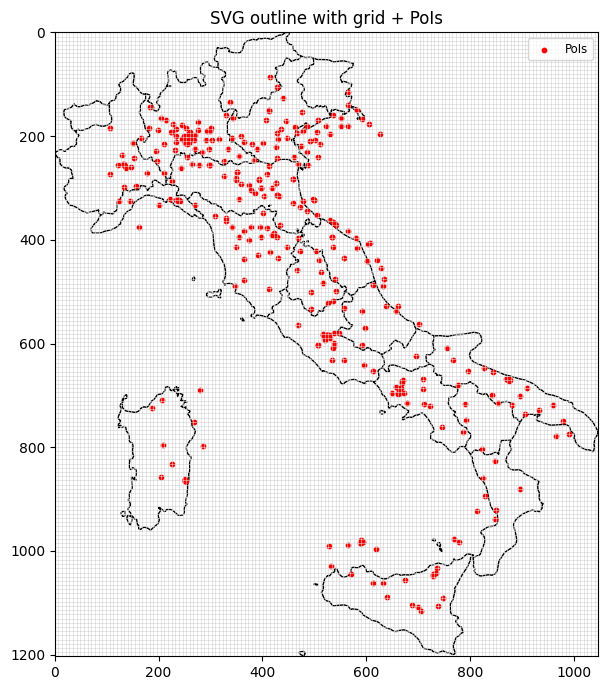

In [106]:

# ─────────────────────────────────────────────────────────────────────────────
# VISUAL CHECK – SVG outline + ORIGINAL grid + PoIs
# ─────────────────────────────────────────────────────────────────────────────
svg_paths, _ = svg2paths(str(svg_file), return_svg_attributes=False,
                         convert_circles_to_paths=False,
                         convert_ellipses_to_paths=False,
                         convert_lines_to_paths=False,
                         convert_polylines_to_paths=False,
                         convert_polygons_to_paths=False,
                         convert_rectangles_to_paths=False)

def svgpath_to_mplpath(svg_path, samples=300):
    """Convert an svgpathtools Path to a matplotlib Path.
    Ensures that each SVG sub‑path starts with a MOVETO so we don’t draw
    spurious connecting lines between disjoint segments (which was the
    cause of the stray arrows / spikes you saw)."""
    verts, codes = [], []
    first_segment = True
    for segment in svg_path:
        ts = np.linspace(0, 1, samples)
        pts = [segment.point(t) for t in ts]
        # start a new sub‑path
        verts.append((pts[0].real, pts[0].imag))
        codes.append(MplPath.MOVETO)
        # continue the segment with straight lines between samples
        for p in pts[1:]:
            verts.append((p.real, p.imag))
            codes.append(MplPath.LINETO)
        first_segment = False
    return MplPath(verts, codes)

fig, ax = plt.subplots(figsize=(7, 7))

# SVG outline
for sp in svg_paths:
    patch = PathPatch(svgpath_to_mplpath(sp), facecolor="none", edgecolor="black", lw=1)
    ax.add_patch(patch)

# Original grid
for a, b in edges:
    ax.plot([grid[a, 0], grid[b, 0]], [grid[a, 1], grid[b, 1]], color="lightgray", lw=0.4)

# Points of Interest
ax.scatter(pois[:, 0], pois[:, 1], marker="o", s=10, color="red", label="PoIs")

ax.set_aspect("equal")
ax.set_xlim(vb_x, vb_x + vb_w)
ax.set_ylim(vb_y, vb_y + vb_h)
ax.set_title("SVG outline with grid + PoIs")
ax.legend(loc="upper right", fontsize="small")
# Flip Y‑axis so SVG (origin top‑left) aligns with Matplotlib plot
ax.set_ylim(vb_y + vb_h, vb_y)  # invert y
plt.tight_layout()
plt.tight_layout()
plt.show()

/tmp/ipykernel_19135/3222534705.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_19135/3222534705.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/marco/DataspellProjects/choromorph/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


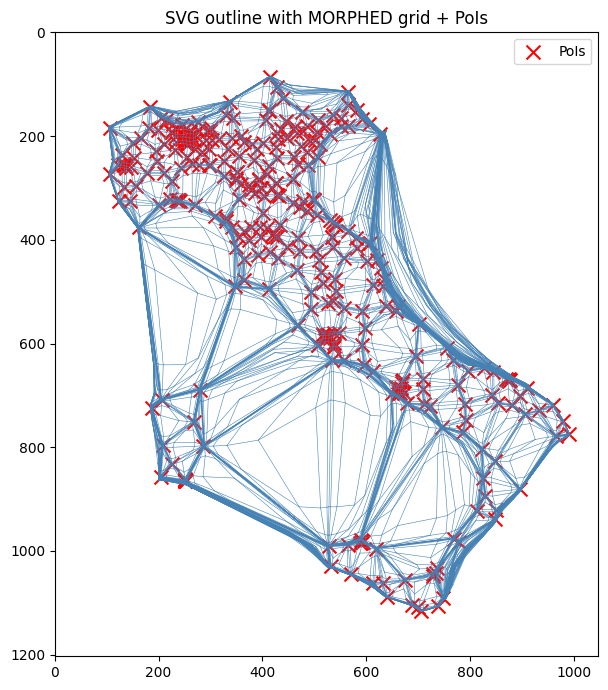

In [107]:

# ─────────────────────────────────────────────────────────────────────────────
# VISUAL CHECK – SVG outline + MORPHED grid + PoIs
# ─────────────────────────────────────────────────────────────────────────────
fig2, ax2 = plt.subplots(figsize=(7, 7))

# Morphed grid
for a, b in edges:
    ax2.plot([morphed[a, 0], morphed[b, 0]], [morphed[a, 1], morphed[b, 1]],
             color="steelblue", lw=0.4)

# Points of Interest
ax2.scatter(pois[:, 0], pois[:, 1], marker="x", s=100, color="red", label="PoIs")

ax2.set_aspect("equal")
ax2.set_xlim(vb_x, vb_x + vb_w)
ax2.set_ylim(vb_y, vb_y + vb_h)
ax2.set_title("SVG outline with MORPHED grid + PoIs")
ax2.legend()
# Flip Y‑axis to match SVG coordinate space
ax2.set_ylim(vb_y + vb_h, vb_y)
plt.tight_layout()
plt.tight_layout()
plt.show()


In [108]:

# ─────────────────────────────────────────────────────────────────────────────
# 8. Save & show the warped SVG
# ─────────────────────────────────────────────────────────────────────────────
wsvg(warped_paths, filename=str(output_svg))
print(f"Warped SVG saved to → {output_svg}")

# Display inline if in Jupyter
try:
    display(SVG(filename=str(output_svg)))
except NameError:
    pass


Warped SVG saved to → ../images/italy_map_no_grid_warped.svg


In [109]:
# -----------------------------------------------------------------
# 9.  Esporta un SVG con i soli PoI
# -----------------------------------------------------------------
from pathlib import Path

poi_svg_path = Path("../images/ivg_pois.svg")  # dove salvare

# (1) header con stesso viewBox dell'Italia
svg_header = (
    f'<svg xmlns="http://www.w3.org/2000/svg" '
    f'viewBox="{vb_x} {vb_y} {vb_w} {vb_h}" '
    f'shape-rendering="crispEdges">\n'
)

# (2) un cerchietto per ogni PoI
circles = "\n".join(
    f'  <circle cx="{x:.2f}" cy="{y:.2f}" r="3" '
    f'fill="#e41a1c"/>'
    for x, y in pois
)

# (3) chiusura tag e salvataggio
with open(poi_svg_path, "w", encoding="utf-8") as f:
    f.write(svg_header + circles + "\n</svg>")

print(f"✅  PoI SVG salvato in → {poi_svg_path.resolve()}")


✅  PoI SVG salvato in → /home/marco/DataspellProjects/choromorph/images/ivg_pois.svg
